In [3]:
in_path =r'../../data/clean/' # use your path
out_path=r'../../data/clean/'

import pandas as pd
pd.set_option('display.max_columns', 500)
import glob
import re
from nltk import stem
porter = stem.porter.PorterStemmer()
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
    df=pd.read_csv(in_path+"articles.csv")   
    df.DE.fillna('',inplace=True)
    df['doc']=df.AB+'. '+df.TI+'. '+df.DE

In [5]:
    docs_csv=out_path+"docs.csv"
    df.doc.to_csv(docs_csv, index=False)
    
    with open(docs_csv) as f:
        docs = f.readlines()

In [6]:
    docs_cleaned = [[re.sub('[.!,;?()\W\d]+', '', word) for word in doc.lower().split()] for doc in docs]
    stop= open ('stopList.txt').read()
    stop_list = set(stop.replace("\n", " ").split())
    docs_stemed = [[porter.stem(word) for word in document if word not in stop_list] for document in docs_cleaned]
    docs_prepared=out_path+'docs_prepared.csv'
    with open(docs_prepared, 'w') as f:
        for doc in docs_stemed:f.write("%s\n" % ' '.join(doc))        

In [7]:
dictionary = corpora.Dictionary(docs_stemed)
dictionary.filter_extremes(no_below=5)
dictionary.compactify() 
print dictionary

class MyCorpus(object):
    def __iter__(self):
        for doc in docs_stemed:
            yield dictionary.doc2bow(doc)
corpus= MyCorpus() 
corpora.MmCorpus.serialize('serialized.mm', corpus)
corpus = corpora.MmCorpus('serialized.mm')
print corpus

Dictionary(2634 unique tokens: [u'', u'assimil', u'interchang', u'articul', u'payoff']...)
MmCorpus(2101 documents, 2634 features, 130884 non-zero entries)


In [8]:
    tfidf = models.tfidfmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) 
    corpus_lsi=lsi[corpus_tfidf]

    index = similarities.MatrixSimilarity(corpus_lsi) 
    lines = docs_stemed
    sims = open('../csv/lsi.csv', 'w')
    sims.write('source,target,weight,type\n')
    for i in range(len(docs_stemed)):
        doc=lines[i]    
        vec_bow = dictionary.doc2bow(doc)
        vec_tran = lsi[tfidf[vec_bow]]
        #vec_tran = lda[tfidf[vec_bow]]
        simsinx = index[vec_tran]
        for j in range(i+1,len(simsinx)):
            if simsinx[j]>.5:                                        
                sims.write(str(i)+','+str(j)+','+str(simsinx[j])+',undirected\n')
    sims.close()

In [9]:
lsi_df=pd.read_csv('../csv/lsi.csv')
lsi_df=lsi_df[lsi_df.weight>.5]
lsi_df.shape

(24434, 4)

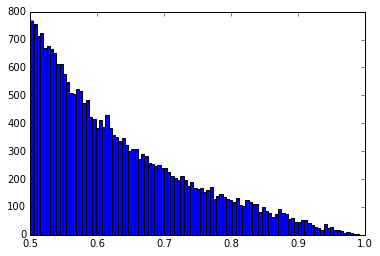

In [10]:
import numpy as np
l=lsi_df.weight
hist=plt.hist(l,101)

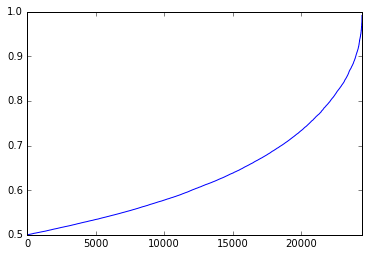

In [11]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

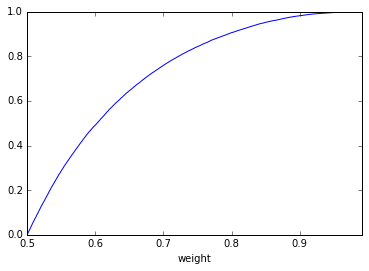

In [12]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

In [13]:
dic=cdf.to_dict()
lsi_df['p']=lsi_df.weight.apply(lambda x :1- dic[x])

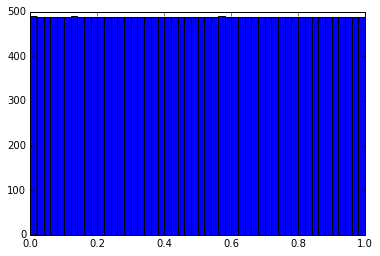

In [14]:
p=lsi_df.p
binwidth=.01
hist=plt.hist(p,50 )

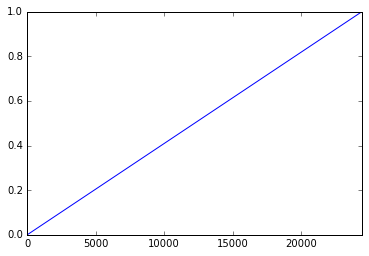

In [15]:
p=lsi_df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [16]:
lsi_df['original_weight']=lsi_df.weight
lsi_df.drop('weight',inplace=True,axis=1)
lsi_df['weight']=1-lsi_df.p
lsi_df[['source','target','weight','type']].to_csv('../csv/p_lsi.csv',index=False)

In [17]:
lsi_df.shape

(24434, 6)

In [19]:
df[df.index==1473]

,Unnamed: 0,﻿PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,SE,BS,LA,DT,CT,CY,CL,SP,HO,DE,ID,AB,C1,RP,EM,RI,OI,FU,FX,CR,NR,TC,Z9,U1,U2,PU,PI,PA,SN,EI,BN,J9,JI,PD,PY,VL,IS,PN,SU,SI,MA,BP,EP,AR,DI,D2,PG,WC,SC,GA,UT,PM,id,doc
1473,1473,J,"Myers, MD",NaN,NaN,NaN,"Myers, MD",NaN,NaN,Qualitative research in information systems,MIS QUARTERLY,NaN,NaN,English,Article,NaN,NaN,NaN,NaN,NaN,research methodology; action research; case st...,NaN,Qualitative research involves the use of quali...,NaN,"Myers, MD (reprint author), UNIV AUCKLAND,DEPT...",NaN,"Myers, Michael/F-9405-2010","Myers, Michael/0000-0001-8525-6395",NaN,NaN,NaN,0,237,242,6,67,SOC INFORM MANAGE-MIS RES CENT,MINNEAPOLIS,UNIV MINNESOTA-SCH MANAGEMENT 271 19TH AVE SOU...,0276-7783,NaN,NaN,MIS QUART,MIS Q.,JUN,1997,21,2.0,NaN,NaN,NaN,NaN,241,242,NaN,10.2307/249422,NaN,2,"Computer Science, Information Systems; Informa...",Computer Science; Information Science & Librar...,XX650,WOS:A1997XX65000008,NaN,1473,Qualitative research involves the use of quali...
